In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [16]:
import torch
import os
import util
import json

BASE_PATH = '../logs'
train_datasets = ['sf_xs']
test_datasets = ['tokyo_xs', 'tokyo_night']
variants = ['standard', 'seed_3', 'cl_lr_e-3', 'attention', 'toDay']
losses = ['cosface', 'sphereface', 'arcface', 'gamp']
models = [f'{loss}_{variant}' for loss in losses for variant in variants]
recalls = { m: { d: 0.0 for d in (train_datasets + test_datasets) } for m in models if m not in [f'{loss}_toDay' for loss in losses if loss != 'cosface'] }

for folder in os.listdir(BASE_PATH):
    loss = folder.split('_')[1]
    if str(folder).startswith('train'):
        for dataset in train_datasets:
            for idx, results in enumerate(os.listdir(f'{BASE_PATH}/{folder}')[2::3]):
                variant = variants[idx]
                file_path = f'{BASE_PATH}/{folder}/{results}/info.log'
                model = f'{loss}_{variant}'
                # print(f'{dataset}: {model} at {file_path}')
                with open(file_path) as f:
                    recalls[model][dataset] = float(next((l.split('>: ')[1].split(',')[0].split(': ')[1] for l in f.readlines() if 'R@1' in l and 'test' in l), 0.0))           
                    recalls[model]['path'] = f'{BASE_PATH}/{folder}/{results}/best_model.pth'        
    elif str(folder).startswith('test'):
        for dataset in test_datasets:
            for idx, results in enumerate(os.listdir(f'{BASE_PATH}/{folder}/{dataset}')):
                variant = variants[idx]
                file_path = f'{BASE_PATH}/{folder}/{dataset}/{results}/info.log'
                model = f'{loss}_{variant}'
                # print(f'{dataset}: {model} at {file_path}')
                with open(file_path) as f:
                    recalls[model][dataset] = float(next((l.split('>: ')[1].split(',')[0].split(': ')[1] for l in f.readlines() if 'R@1' in l and 'test' in l), 0.0))          

recalls = dict(sorted(recalls.items(), key=lambda i: tuple(i[1][d] for d in (train_datasets + test_datasets)), reverse=True))
# recalls = dict(sorted(recalls.items(), key=lambda i: tuple(i[1][d] for d in (test_datasets + train_datasets)), reverse=True))
# recalls = dict(sorted(recalls.items(), key=lambda i: tuple(i[1][d] for d in reversed(train_datasets + test_datasets)), reverse=True))
with open('../results/individual_models.json', 'w') as f:
    json.dump(recalls, f, indent=4)

In [14]:
sf_xs_sorted_models = []
tokyo_xs_sorted_models = []
tokyo_night_sorted_models = []

print('Sorting by sf_xs test desc')
for m in dict(sorted(recalls.items(), key=lambda i: tuple(i[1][d] for d in (train_datasets + test_datasets)), reverse=True)):
    if 'attention' not in m:
        sf_xs_sorted_models.append(recalls[m]['path'])
print(' '.join([p for p in sf_xs_sorted_models]))

print('Sorting by tokyo_xs test desc')
for m in dict(sorted(recalls.items(), key=lambda i: tuple(i[1][d] for d in (test_datasets + train_datasets)), reverse=True)):
    if 'attention' not in m:
        tokyo_xs_sorted_models.append(recalls[m]['path'])
print(' '.join([p for p in tokyo_xs_sorted_models]))

print('Sorting by tokyo_night test desc')
for m in dict(sorted(recalls.items(), key=lambda i: tuple(i[1][d] for d in reversed(train_datasets + test_datasets)), reverse=True)):
    if 'attention' not in m:
        tokyo_night_sorted_models.append(recalls[m]['path'])
print(' '.join([p for p in tokyo_night_sorted_models]))

Sorting by sf_xs test desc
F:/Programmazione/git/advanced-machine-learning/logs/train_arcface/2023-01-12_15-32-47/best_model.pth F:/Programmazione/git/advanced-machine-learning/logs/train_gamp/2023-01-11_15-26-26/best_model.pth F:/Programmazione/git/advanced-machine-learning/logs/train_sphereface/2023-01-13_12-24-32/best_model.pth F:/Programmazione/git/advanced-machine-learning/logs/train_sphereface/2023-01-10_12-32-50/best_model.pth F:/Programmazione/git/advanced-machine-learning/logs/train_cosface/2023-01-12_08-59-21/best_model.pth F:/Programmazione/git/advanced-machine-learning/logs/train_cosface/2023-01-09_10-21-22/best_model.pth F:/Programmazione/git/advanced-machine-learning/logs/train_gamp/2023-01-11_10-12-16/best_model.pth F:/Programmazione/git/advanced-machine-learning/logs/train_sphereface/2023-01-07_13-16-38/best_model.pth F:/Programmazione/git/advanced-machine-learning/logs/train_arcface/2023-01-06_16-41-53/best_model.pth F:/Programmazione/git/advanced-machine-learning/logs

In [3]:
import torch
import os
import util
import json
import test
from datasets.test_dataset import TestDataset
import argparse
from model import network

BASE_OUT_PATH = 'logs/soups_models/uniform'
BASE_DS_PATH = f"F:/Programmazione/Politecnico/Master's Degree/2nd Year/AML/Project/Datasets"

NUM_MODELS = len(recalls)

parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
# CosPlace Groups parameters
parser.add_argument("--M", type=int, default=10, help="_")
parser.add_argument("--alpha", type=int, default=30, help="_")
parser.add_argument("--N", type=int, default=5, help="_")
parser.add_argument("--L", type=int, default=2, help="_")
parser.add_argument("--groups_num", type=int, default=8, help="_")
parser.add_argument("--min_images_per_class", type=int, default=10, help="_")
# Model parameters
parser.add_argument("--backbone", type=str, default="ResNet18",
                    choices=["vgg16", "resnet18", "resnet50", "resnet101", "resnet152"], help="_")
parser.add_argument("--fc_output_dim", type=int, default=512,
                    help="Output dimension of final fully connected layer")
# Training parameters
parser.add_argument("--use_amp16", action="store_true",
                    help="use Automatic Mixed Precision")
parser.add_argument("--augmentation_device", type=str, default="cuda",
                    choices=["cuda", "cpu"],
                    help="on which device to run data augmentation")
parser.add_argument("--batch_size", type=int, default=32, help="_")
parser.add_argument("--epochs_num", type=int, default=50, help="_")
parser.add_argument("--iterations_per_epoch", type=int, default=10000, help="_")
parser.add_argument("--lr", type=float, default=0.00001, help="_")
parser.add_argument("--classifiers_lr", type=float, default=0.01, help="_")
# Data augmentation
parser.add_argument("--brightness", type=float, default=0.7, help="_")
parser.add_argument("--contrast", type=float, default=0.7, help="_")
parser.add_argument("--hue", type=float, default=0.5, help="_")
parser.add_argument("--saturation", type=float, default=0.7, help="_")
parser.add_argument("--random_resized_crop", type=float, default=0.5, help="_")
# Validation / test parameters
parser.add_argument("--infer_batch_size", type=int, default=16,
                    help="Batch size for inference (validating and testing)")
parser.add_argument("--positive_dist_threshold", type=int, default=25,
                    help="distance in meters for a prediction to be considered a positive")
# Resume parameters
parser.add_argument("--resume_train", type=str, default=None,
                    help="path to checkpoint to resume, e.g. logs/.../last_checkpoint.pth")
parser.add_argument("--resume_model", type=str, default=None,
                    help="path to model to resume, e.g. logs/.../best_model.pth")
# Other parameters
parser.add_argument("--device", type=str, default="cuda",
                    choices=["cuda", "cpu"], help="_")
parser.add_argument("--seed", type=int, default=0, help="_")
parser.add_argument("--num_workers", type=int, default=4, help="_")
# Paths parameters
parser.add_argument("--dataset_folder", type=str, default=None,
                    help="path of the folder with train/val/test sets")
parser.add_argument("--save_dir", type=str, default="default",
                    help="name of directory on which to save the logs, under logs/save_dir")    
# Loss type
parser.add_argument("--loss_type", type=str, default="cosface",
                    choices=["cosface", "arcface", "sphereface", "gamp"], help="type of loss to be used during training")

args = parser.parse_args("")
args.save_descriptors = False        

print(args)

if os.path.exists(f'{BASE_OUT_PATH}/uniform_soup_N{NUM_MODELS}.pth'):
    uniform_soup = torch.load(f'{BASE_OUT_PATH}/uniform_soup_N{NUM_MODELS}.pth')
else:
    for j, model_name in enumerate(recalls):

        print(f'Adding model {model_name} ({j+1} out of {NUM_MODELS}) to uniform soup.')
        model_path = recalls[model_name]['path']
        assert os.path.exists(model_path)
        state_dict = torch.load(model_path)
        if j == 0:
            uniform_soup = {k : v * (1./NUM_MODELS) for k, v in state_dict.items()}
        else:
            uniform_soup = {k : v * (1./NUM_MODELS) + uniform_soup[k] for k, v in state_dict.items()}

    torch.save(uniform_soup, f'{BASE_OUT_PATH}/uniform_soup_N{NUM_MODELS}.pth')

# Finally, evaluate the uniform soup.
model = network.GeoLocalizationNet(args.backbone, args.fc_output_dim)
model.load_state_dict(uniform_soup)
model.to(args.device)

if os.path.exists('uniform_soups.json'):
    with open('uniform_soups.json', 'r') as f:
        uniform_recalls = json.load(f)
else:
    uniform_recalls = dict()  
uniform_recalls[f'uniform_soup_N{NUM_MODELS}'] = { }

for dataset in (train_datasets + test_datasets):
    print(f'Evaluating on {dataset}.')
    test_dataset = TestDataset(f'{BASE_DS_PATH}/{dataset}/test', queries_folder='queries_v1')
    recs, recalls_str = test.test(args, test_dataset, model)
    uniform_recalls[f'uniform_soup_N{NUM_MODELS}'][dataset] = recs[0]
    print(recs)

with open('uniform_soups.json', 'w') as f:
    json.dump(uniform_recalls, f, indent=4)

Namespace(M=10, alpha=30, N=5, L=2, groups_num=8, min_images_per_class=10, backbone='ResNet18', fc_output_dim=512, use_amp16=False, augmentation_device='cuda', batch_size=32, epochs_num=50, iterations_per_epoch=10000, lr=1e-05, classifiers_lr=0.01, brightness=0.7, contrast=0.7, hue=0.5, saturation=0.7, random_resized_crop=0.5, infer_batch_size=16, positive_dist_threshold=25, resume_train=None, resume_model=None, device='cuda', seed=0, num_workers=4, dataset_folder=None, save_dir='default', loss_type='cosface', save_descriptors=False)
Evaluating on sf_xs.


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.72it/s]


[49.3 62.6 67.8 72.8]
Evaluating on tokyo_xs.


100%|█████████████████████████████████████████████████████████████| 315/315 [00:14<00:00, 21.00it/s]


[65.3968254  80.31746032 85.07936508 90.15873016]
Evaluating on tokyo_night.


100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.21it/s]

[46.66666667 64.76190476 74.28571429 81.9047619 ]


In [20]:
import torch
from itertools import islice
from datasets.test_dataset import TestDataset
from model import network
import test
import argparse

NUM_MODELS = 12
BASE_DS_PATH = f"F:/Programmazione/Politecnico/Master's Degree/2nd Year/AML/Project/Datasets"
BASE_OUT_PATH = 'logs/soups_models/greedy'
chosen_dataset = ('tokyo_night', 'test')
TOKYO_XS_DATASET_VAL_PATH = f"{BASE_DS_PATH}/{chosen_dataset[0]}/{chosen_dataset[1]}"
held_out_val_set = TestDataset(TOKYO_XS_DATASET_VAL_PATH, queries_folder="queries_v1")

parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
# CosPlace Groups parameters
parser.add_argument("--M", type=int, default=10, help="_")
parser.add_argument("--alpha", type=int, default=30, help="_")
parser.add_argument("--N", type=int, default=5, help="_")
parser.add_argument("--L", type=int, default=2, help="_")
parser.add_argument("--groups_num", type=int, default=8, help="_")
parser.add_argument("--min_images_per_class", type=int, default=10, help="_")
# Model parameters
parser.add_argument("--backbone", type=str, default="ResNet18",
                    choices=["vgg16", "resnet18", "resnet50", "resnet101", "resnet152"], help="_")
parser.add_argument("--fc_output_dim", type=int, default=512,
                    help="Output dimension of final fully connected layer")
# Training parameters
parser.add_argument("--use_amp16", action="store_true",
                    help="use Automatic Mixed Precision")
parser.add_argument("--augmentation_device", type=str, default="cuda",
                    choices=["cuda", "cpu"],
                    help="on which device to run data augmentation")
parser.add_argument("--batch_size", type=int, default=32, help="_")
parser.add_argument("--epochs_num", type=int, default=50, help="_")
parser.add_argument("--iterations_per_epoch", type=int, default=10000, help="_")
parser.add_argument("--lr", type=float, default=0.00001, help="_")
parser.add_argument("--classifiers_lr", type=float, default=0.01, help="_")
# Data augmentation
parser.add_argument("--brightness", type=float, default=0.7, help="_")
parser.add_argument("--contrast", type=float, default=0.7, help="_")
parser.add_argument("--hue", type=float, default=0.5, help="_")
parser.add_argument("--saturation", type=float, default=0.7, help="_")
parser.add_argument("--random_resized_crop", type=float, default=0.5, help="_")
# Validation / test parameters
parser.add_argument("--infer_batch_size", type=int, default=16,
                    help="Batch size for inference (validating and testing)")
parser.add_argument("--positive_dist_threshold", type=int, default=25,
                    help="distance in meters for a prediction to be considered a positive")
# Resume parameters
parser.add_argument("--resume_train", type=str, default=None,
                    help="path to checkpoint to resume, e.g. logs/.../last_checkpoint.pth")
parser.add_argument("--resume_model", type=str, default=None,
                    help="path to model to resume, e.g. logs/.../best_model.pth")
# Other parameters
parser.add_argument("--device", type=str, default="cuda",
                    choices=["cuda", "cpu"], help="_")
parser.add_argument("--seed", type=int, default=0, help="_")
parser.add_argument("--num_workers", type=int, default=4, help="_")
# Paths parameters
parser.add_argument("--dataset_folder", type=str, default=None,
                    help="path of the folder with train/val/test sets")
parser.add_argument("--save_dir", type=str, default="default",
                    help="name of directory on which to save the logs, under logs/save_dir")    
# Loss type
parser.add_argument("--loss_type", type=str, default="cosface",
                    choices=["cosface", "arcface", "sphereface", "gamp"], help="type of loss to be used during training")

args = parser.parse_args("")
args.save_descriptors = False        

print(args)

# Now, iterate through all models and consider adding them to the greedy soup.
for i, key in enumerate(islice(recalls, NUM_MODELS)):
    if i == 0:
        # Start the soup by using the first ingredient.
        print(f'Init with model {i+1} of {NUM_MODELS}')
        greedy_soup_ingredients = [key]
        greedy_soup_params = torch.load(recalls[key]['path'])
        best_val_acc_so_far = recalls[key][chosen_dataset[0]]
    else:
        print(f'Testing model {i+1} of {NUM_MODELS}')
        # break        
        # Get the potential greedy soup, which consists of the greedy soup with the new model added.
        new_ingredient_params = torch.load(recalls[key]['path'])
        num_ingredients = len(greedy_soup_ingredients)
        potential_greedy_soup_params = {
            k : greedy_soup_params[k].clone() * (num_ingredients / (num_ingredients + 1.)) + 
                new_ingredient_params[k].clone() * (1. / (num_ingredients + 1))
            for k in new_ingredient_params
        }

        # Run the potential greedy soup on the held-out val set.
        model = network.GeoLocalizationNet(args.backbone, args.fc_output_dim)
        model.load_state_dict(potential_greedy_soup_params)
        model.to(args.device)
        recs, _ = test.test(args, held_out_val_set, model)
        held_out_val_accuracy = recs[0]

        # If accuracy on the held-out val set increases, add the new model to the greedy soup.
        print(f'Potential greedy soup val acc {held_out_val_accuracy}, best so far {best_val_acc_so_far}.')
        if held_out_val_accuracy > best_val_acc_so_far:
            greedy_soup_ingredients.append(key)
            best_val_acc_so_far = held_out_val_accuracy
            greedy_soup_params = potential_greedy_soup_params
            print(f'Adding to soup. New soup is {greedy_soup_ingredients}')

# Finally, evaluate the greedy soup.
model = network.GeoLocalizationNet(args.backbone, args.fc_output_dim)
model.load_state_dict(greedy_soup_params)
model.to(args.device)
print(f'Final soup is {greedy_soup_ingredients}')

if os.path.exists('greedy_soups.json'):
    with open('greedy_soups.json', 'r') as f:
        greedy_recalls = json.load(f)
else:
    greedy_recalls = dict()  

greedy_recalls[f'greedy_soup_N{NUM_MODELS}_{TOKYO_XS_DATASET_VAL_PATH.replace(f"{BASE_DS_PATH}/", "").replace("/", "_")}'] = { } 

for dataset in (train_datasets + test_datasets):
    print(f'Evaluating on {dataset}.')
    test_dataset = TestDataset(f'{BASE_DS_PATH}/{dataset}/test', queries_folder='queries_v1')
    recs, recalls_str = test.test(args, test_dataset, model)
    greedy_recalls[f'greedy_soup_N{NUM_MODELS}_{TOKYO_XS_DATASET_VAL_PATH.replace(f"{BASE_DS_PATH}/", "").replace("/", "_")}'][dataset] = recs[0]
    print(recs)

torch.save(greedy_soup_params, f'{BASE_OUT_PATH}/greedy_soup_N{NUM_MODELS}_{TOKYO_XS_DATASET_VAL_PATH.replace(f"{BASE_DS_PATH}/", "").replace("/", "_")}.pth')
with open('greedy_soups.json', 'w') as f:
    json.dump(greedy_recalls, f, indent=4)

Namespace(M=10, alpha=30, N=5, L=2, groups_num=8, min_images_per_class=10, backbone='resnet18', fc_output_dim=512, use_amp16=False, augmentation_device='cuda', batch_size=32, epochs_num=50, iterations_per_epoch=10000, lr=1e-05, classifiers_lr=0.01, brightness=0.7, contrast=0.7, hue=0.5, saturation=0.7, random_resized_crop=0.5, infer_batch_size=16, positive_dist_threshold=25, resume_train=None, resume_model=None, device='cuda', seed=0, num_workers=4, dataset_folder=None, save_dir='default', loss_type='cosface', save_descriptors=False)
Init with model 1 of 12
Testing model 2 of 12


f:\Programmazione\git\advanced-machine-learning\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\Programmazione\git\advanced-machine-learning\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.45it/s]


Potential greedy soup val acc 55.23809523809524, best so far 57.1.
Testing model 3 of 12


100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.40it/s]


Potential greedy soup val acc 56.19047619047619, best so far 57.1.
Testing model 4 of 12


100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.38it/s]


Potential greedy soup val acc 50.476190476190474, best so far 57.1.
Testing model 5 of 12


100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.47it/s]


Potential greedy soup val acc 53.333333333333336, best so far 57.1.
Testing model 6 of 12


100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.23it/s]


Potential greedy soup val acc 53.333333333333336, best so far 57.1.
Testing model 7 of 12


100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.43it/s]


Potential greedy soup val acc 53.333333333333336, best so far 57.1.
Testing model 8 of 12


100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.46it/s]


Potential greedy soup val acc 53.333333333333336, best so far 57.1.
Testing model 9 of 12


100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.69it/s]


Potential greedy soup val acc 58.0952380952381, best so far 57.1.
Adding to soup. New soup is ['sphereface_seed_3', 'sphereface_cl_lr_e-3']
Testing model 10 of 12


100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.68it/s]


Potential greedy soup val acc 50.476190476190474, best so far 58.0952380952381.
Testing model 11 of 12


100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.74it/s]


Potential greedy soup val acc 53.333333333333336, best so far 58.0952380952381.
Testing model 12 of 12


100%|█████████████████████████████████████████████████████████████| 105/105 [00:11<00:00,  8.78it/s]


Potential greedy soup val acc 53.333333333333336, best so far 58.0952380952381.
Final soup is ['sphereface_seed_3', 'sphereface_cl_lr_e-3']
Evaluating on sf_xs.


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 43.35it/s]


[48.5 63.2 68.2 72.2]
Evaluating on tokyo_xs.


100%|█████████████████████████████████████████████████████████████| 315/315 [00:14<00:00, 21.72it/s]


[70.47619048 85.3968254  87.93650794 90.79365079]
Evaluating on tokyo_night.


100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.49it/s]

[58.0952381  72.38095238 77.14285714 81.9047619 ]


In [12]:
import torch
from itertools import islice
from datasets.test_dataset import TestDataset
from model import network
import test
import argparse

NUM_MODELS = 12
BASE_DS_PATH = f"F:/Programmazione/Politecnico/Master's Degree/2nd Year/AML/Project/Datasets"
BASE_OUT_PATH = 'logs/soups_models/ensemble'

parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
# CosPlace Groups parameters
parser.add_argument("--M", type=int, default=10, help="_")
parser.add_argument("--alpha", type=int, default=30, help="_")
parser.add_argument("--N", type=int, default=5, help="_")
parser.add_argument("--L", type=int, default=2, help="_")
parser.add_argument("--groups_num", type=int, default=8, help="_")
parser.add_argument("--min_images_per_class", type=int, default=10, help="_")
# Model parameters
parser.add_argument("--backbone", type=str, default="ResNet18",
                    choices=["vgg16", "resnet18", "resnet50", "resnet101", "resnet152"], help="_")
parser.add_argument("--fc_output_dim", type=int, default=512,
                    help="Output dimension of final fully connected layer")
# Training parameters
parser.add_argument("--use_amp16", action="store_true",
                    help="use Automatic Mixed Precision")
parser.add_argument("--augmentation_device", type=str, default="cuda",
                    choices=["cuda", "cpu"],
                    help="on which device to run data augmentation")
parser.add_argument("--batch_size", type=int, default=32, help="_")
parser.add_argument("--epochs_num", type=int, default=50, help="_")
parser.add_argument("--iterations_per_epoch", type=int, default=10000, help="_")
parser.add_argument("--lr", type=float, default=0.00001, help="_")
parser.add_argument("--classifiers_lr", type=float, default=0.01, help="_")
# Data augmentation
parser.add_argument("--brightness", type=float, default=0.7, help="_")
parser.add_argument("--contrast", type=float, default=0.7, help="_")
parser.add_argument("--hue", type=float, default=0.5, help="_")
parser.add_argument("--saturation", type=float, default=0.7, help="_")
parser.add_argument("--random_resized_crop", type=float, default=0.5, help="_")
# Validation / test parameters
parser.add_argument("--infer_batch_size", type=int, default=16,
                    help="Batch size for inference (validating and testing)")
parser.add_argument("--positive_dist_threshold", type=int, default=25,
                    help="distance in meters for a prediction to be considered a positive")
# Resume parameters
parser.add_argument("--resume_train", type=str, default=None,
                    help="path to checkpoint to resume, e.g. logs/.../last_checkpoint.pth")
parser.add_argument("--resume_model", type=str, default=None,
                    help="path to model to resume, e.g. logs/.../best_model.pth")
# Other parameters
parser.add_argument("--device", type=str, default="cuda",
                    choices=["cuda", "cpu"], help="_")
parser.add_argument("--seed", type=int, default=0, help="_")
parser.add_argument("--num_workers", type=int, default=4, help="_")
# Paths parameters
parser.add_argument("--dataset_folder", type=str, default=None,
                    help="path of the folder with train/val/test sets")
parser.add_argument("--save_dir", type=str, default="default",
                    help="name of directory on which to save the logs, under logs/save_dir")    
# Loss type
parser.add_argument("--loss_type", type=str, default="cosface",
                    choices=["cosface", "arcface", "sphereface", "gamp"], help="type of loss to be used during training")

args = parser.parse_args("")

args.save_descriptors = True    

print(args)

if os.path.exists('ensembles.json'):
    with open('ensembles.json', 'r') as f:
        ensembles_recalls = json.load(f) 
else:
    ensembles_recalls = dict() 
ensembles_recalls[f'descriptors_{NUM_MODELS}'] = { }

for dataset in (train_datasets + test_datasets):
    recalls = dict(sorted(recalls.items(), key=lambda i: i[1][dataset], reverse=True))
    print(f'Evaluating on {dataset}.')

    descriptors = None
    models = list()
    best_recs = None

    for i, key in enumerate(islice(recalls, NUM_MODELS)):
        if not os.path.exists(recalls[key]['path'].replace('best_model.pth', f'{dataset}/')):
            print(f"Creating directory {recalls[key]['path'].replace('best_model.pth', f'{dataset}/')}")
            os.mkdir(recalls[key]['path'].replace('best_model.pth', f'{dataset}/'))

        if i == 0:
            # print(f'Use descriptors from model {key} ({i + 1} out of {NUM_MODELS})')
            try:
                descriptors = torch.load(recalls[key]['path'].replace('best_model.pth', f'{dataset}/descriptors.pth'))
            except FileNotFoundError:
                model = network.GeoLocalizationNet(args.backbone, args.fc_output_dim)
                model.load_state_dict(torch.load(recalls[key]['path']))
                model.to(args.device)
                test_dataset = TestDataset(f'{BASE_DS_PATH}/{dataset}/test', queries_folder='queries_v1')
                _, __ = test.test(args, test_dataset, model, recalls[key]['path'].replace('best_model.pth', dataset))
                descriptors = torch.load(recalls[key]['path'].replace('best_model.pth', f'{dataset}/descriptors.pth'))
        else:
            # print(f'Use descriptors from model {key} ({i + 1} out of {NUM_MODELS})')
            try:
                to_add = torch.load(recalls[key]['path'].replace('best_model.pth', f'{dataset}/descriptors.pth'))
            except FileNotFoundError:
                model = network.GeoLocalizationNet(args.backbone, args.fc_output_dim)
                model.load_state_dict(torch.load(recalls[key]['path']))
                model.to(args.device)
                test_dataset = TestDataset(f'{BASE_DS_PATH}/{dataset}/test', queries_folder='queries_v1')
                _, __ = test.test(args, test_dataset, model, recalls[key]['path'].replace('best_model.pth', dataset))
                to_add = torch.load(recalls[key]['path'].replace('best_model.pth', f'{dataset}/descriptors.pth'))
            descriptors += to_add 

        test_dataset = TestDataset(f'{BASE_DS_PATH}/{dataset}/test', queries_folder='queries_v1')
        predictions = test.get_predictions(test_dataset, args.fc_output_dim, descriptors/(float(i+1)))   
        recs = test.evaluate_predictions(predictions, test_dataset)
        recs = tuple(recs / test_dataset.queries_num * 100)
        # print(f'Results on ensemble of {models + [key]}: {recs}')

        if best_recs is None or recs > best_recs:
            models.append(key)
            best_recs = recs
            best_descriptors = descriptors
            print(f'Adding to ensemble on {dataset}. New ensemble is {models} with recalls {recs}')

    print(f'Best ensemble on {dataset}: {models} with recalls {best_recs}')
    best_descriptors = best_descriptors / float(NUM_MODELS)
    torch.save(best_descriptors, f'{BASE_OUT_PATH}/descriptors_{NUM_MODELS}_{dataset}_test.pth')
    
    ensembles_recalls[f'descriptors_{NUM_MODELS}'][dataset] = best_recs[0]

    with open('ensembles.json', 'w') as f:
        json.dump(ensembles_recalls, f, indent=4)

Namespace(M=10, alpha=30, N=5, L=2, groups_num=8, min_images_per_class=10, backbone='ResNet18', fc_output_dim=512, use_amp16=False, augmentation_device='cuda', batch_size=32, epochs_num=50, iterations_per_epoch=10000, lr=1e-05, classifiers_lr=0.01, brightness=0.7, contrast=0.7, hue=0.5, saturation=0.7, random_resized_crop=0.5, infer_batch_size=16, positive_dist_threshold=25, resume_train=None, resume_model=None, device='cuda', seed=0, num_workers=4, dataset_folder=None, save_dir='default', loss_type='cosface', save_descriptors=True)
Evaluating on sf_xs.
Adding to ensemble on sf_xs. New ensemble is ['arcface_cl_lr_e-3'] with recalls (53.5, 65.8, 71.2, 75.0)
Adding to ensemble on sf_xs. New ensemble is ['arcface_cl_lr_e-3', 'sphereface_seed_3'] with recalls (53.6, 66.7, 71.2, 75.8)
Adding to ensemble on sf_xs. New ensemble is ['arcface_cl_lr_e-3', 'sphereface_seed_3', 'sphereface_standard'] with recalls (53.6, 66.7, 71.3, 75.4)
Adding to ensemble on sf_xs. New ensemble is ['arcface_cl_lr

In [20]:
for m in os.listdir('logs/soups_models/greedy'):
    greedy_soup_params = torch.load(f'logs/soups_models/greedy/{m}')
    model = network.GeoLocalizationNet(args.backbone, args.fc_output_dim)
    model.load_state_dict(greedy_soup_params)
    model.to(args.device)

    if os.path.exists('greedy_soups.json'):
        with open('greedy_soups.json', 'r') as f:
            greedy_recalls = json.load(f) 
    else:
        greedy_recalls = dict()
    greedy_recalls[m.replace('.pth', '')] = { } 

    for dataset in (train_datasets + test_datasets):
        print(f'Evaluating on {dataset}.')
        test_dataset = TestDataset(f'{BASE_DS_PATH}/{dataset}/test', queries_folder='queries_v1')
        recs, recalls_str = test.test(args, test_dataset, model)
        greedy_recalls[m.replace('.pth', '')][dataset] = recs[0]
        print(recs)

    with open('greedy_soups.json', 'w') as f:
        json.dump(greedy_recalls, f, indent=4)

Evaluating on sf_xs.


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.34it/s]


[48.5 63.2 68.2 72.2]
Evaluating on tokyo_xs.


100%|█████████████████████████████████████████████████████████████| 315/315 [00:15<00:00, 20.95it/s]


[70.47619048 85.3968254  87.93650794 90.79365079]
Evaluating on tokyo_night.


100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.53it/s]


[58.0952381  72.38095238 77.14285714 81.9047619 ]
Evaluating on sf_xs.


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.77it/s]


[50.3 64.9 69.  73. ]
Evaluating on tokyo_xs.


100%|█████████████████████████████████████████████████████████████| 315/315 [00:14<00:00, 21.77it/s]


[70.79365079 83.80952381 88.25396825 93.01587302]
Evaluating on tokyo_night.


100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.48it/s]


[56.19047619 69.52380952 78.0952381  88.57142857]
Evaluating on sf_xs.


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.30it/s]


[52.4 65.8 70.7 74.8]
Evaluating on tokyo_xs.


100%|█████████████████████████████████████████████████████████████| 315/315 [00:15<00:00, 21.00it/s]


[69.20634921 84.12698413 87.3015873  92.6984127 ]
Evaluating on tokyo_night.


100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.51it/s]


[47.61904762 71.42857143 75.23809524 83.80952381]
Evaluating on sf_xs.


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.31it/s]


[52.1 66.3 71.1 75.3]
Evaluating on tokyo_xs.


100%|█████████████████████████████████████████████████████████████| 315/315 [00:14<00:00, 21.01it/s]


[69.20634921 83.17460317 88.57142857 93.33333333]
Evaluating on tokyo_night.


100%|█████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.48it/s]

[48.57142857 69.52380952 78.0952381  84.76190476]


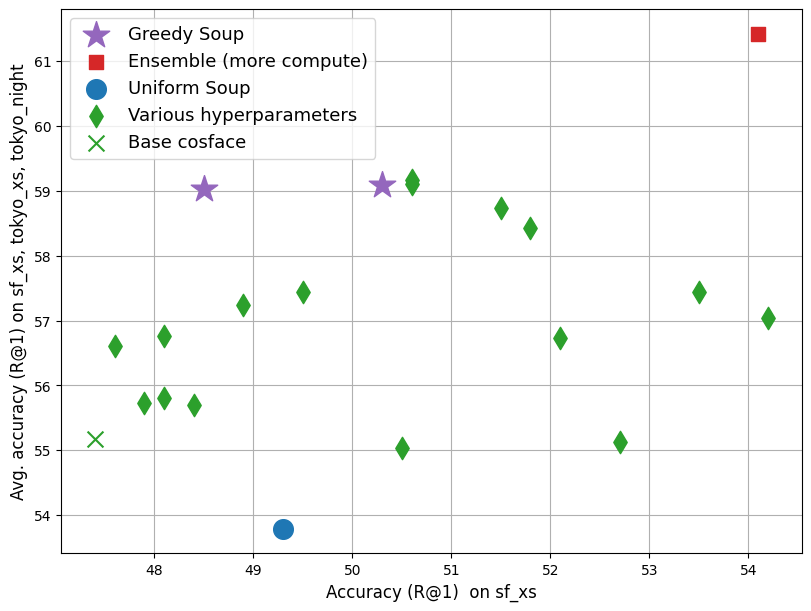

In [1]:
from matplotlib import pyplot as plt
import json

datasets = ['sf_xs', 'tokyo_xs', 'tokyo_night']

with open('../results/individual_models.json', 'r') as f:
    individual_models = json.load(f)

individual_model_db = { d: [individual_models[k][d] for k in individual_models] for d in datasets }
individual_model_db['OOD'] = [1./len(datasets) * sum(individual_model_db[d][i] for d in datasets) for i, _ in enumerate(individual_models)]

with open('../results/uniform_soups.json', 'r') as f:
    uniform_soups = json.load(f)

uniform_soup_db = { d: [uniform_soups[k][d] for k in uniform_soups] for d in datasets }
uniform_soup_db['OOD'] = [1./len(datasets) * sum(uniform_soup_db[d][i] for d in datasets) for i, _ in enumerate(uniform_soups)]

with open('../results/greedy_soups.json', 'r') as f:
    greedy_soups = json.load(f)

greedy_soup_db = { d: [greedy_soups[k][d] for k in greedy_soups] for d in datasets }
greedy_soup_db['OOD'] = [1./len(datasets) * sum(greedy_soup_db[d][i] for d in datasets) for i, _ in enumerate(greedy_soups)]
    
with open('../results/ensembles.json', 'r') as f:
    ensembles = json.load(f)

ensemble_db = { d: [ensembles[k][d] for k in ensembles] for d in datasets }
ensemble_db['OOD'] = [1./len(datasets) * sum(ensemble_db[d][i] for d in datasets) for i, _ in enumerate(ensembles)]

fig = plt.figure(constrained_layout=True, figsize=(8, 6))
ax = fig.subplots()

ax.scatter(
    greedy_soup_db['sf_xs'], 
    greedy_soup_db['OOD'], 
    marker='*', 
    color='C4',
    s=400,
    label='Greedy Soup',
    zorder=10
)

ax.scatter(
    ensemble_db['sf_xs'], 
    ensemble_db['OOD'], 
    marker='s', 
    color='C3',
    s=90,
    label='Ensemble (more compute)',
    zorder=10
)

ax.scatter(
    uniform_soup_db['sf_xs'], 
    uniform_soup_db['OOD'], 
    marker='o', 
    color='C0',
    s=200,
    label='Uniform Soup',
    zorder=10
)

base_idx = list(individual_models).index('cosface_standard')

ax.scatter(
    individual_model_db['sf_xs'][0:base_idx] + individual_model_db['sf_xs'][base_idx+1:], 
    individual_model_db['OOD'][0:base_idx] + individual_model_db['OOD'][base_idx+1:], 
    marker='d', 
    color='C2',
    s=130,
    label='Various hyperparameters',
    zorder=10
)

ax.scatter(
    individual_model_db['sf_xs'][base_idx], 
    individual_model_db['OOD'][base_idx], 
    marker='x', 
    color='C2',
    s=130,
    label='Base cosface',
    zorder=10
)

ax.set_ylabel('Avg. accuracy (R@1) on sf_xs, tokyo_xs, tokyo_night', fontsize=12)
ax.set_xlabel('Accuracy (R@1)  on sf_xs', fontsize=12)
ax.grid()
ax.legend(fontsize=13)
plt.savefig('../results/soups.png', bbox_inches='tight')